# Matching Public Health data (2015) to M&W

Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re #regular expressions 
from fuzzywuzzy import process, fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os 
import glob

In [2]:
%watermark --iversion

UsageError: Line magic function `%watermark` not found.


###### Read in Data

                                                      M&W Data

                                                 Fruit and Vegetables

In [3]:
pd.set_option('display.max_rows', None)
fv = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\FV_MatchedFPSnDoh11.csv", index_col=0)
#redFood.rename(columns={'Similarity Score':'Similarity Score_FPS','Weight':'Weight_FPS','Portion Consumed':'Portion Consumed_FPS'}, inplace=True)
#redFood.drop(['Source','PurEqualCon'], axis=1, inplace=True)
fv['Food Name'] = fv['Food Name'].str.lower()
fv.fillna('').head(2)

,Food Code,Food Name,Food sub-group codes,Food Group,Sales Format,Similarity Score_FPS,Weight_FPS,Portion Consumed_FPS,Similarity Score DoH,Pack Size11,Packaging DoH11,Purchase Date DoH11
0,13-145,ackee,DG,Vegetables,Can,0.000000,,,0.0,,,
1,13-146,agar,DG,Vegetables,Bag,0.276369,,,0.0,,,


                                                Department of Health Data

Text tables

In [4]:
%%time
filtered_products = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FV_WeightData\text\PHealth_text_FV2015.csv", index_col=0)
filtered_products['Sub-sample Number'] = filtered_products['Sub-sample Number'].astype(str)#.head()

CPU times: total: 31.2 ms
Wall time: 8 ms


In [5]:
filtered_products.head(2)

,Composite Sample Number,Composite Sample Name,Sub-sample Number,Sub-sample Name,Brand,Pack size,Purchase Date,Place of Purchase,Display Until Date,Best Before Date,Batch Number,Packaging,Sample Condition As Purchased,Post Purchase Storage
1,1.0,"Kiwi fruit, raw, flesh only",1.2,Tesco kiwi,Tesco,Purchase Date:,19.10.15,"Tesco Extra, Blue Boar Road, Norwich",Use by Date:,NaN,Packaging:,Loose,Ambient,21°C controlled temperature room
3,1.0,"Kiwi fruit, raw, flesh only",1.3,Asda Grower’s Selection ripen at home kiwi fru...,Asda Grower’s Selection,6 fruits,28.09.15,"Asda, Boundary Road, Norwich",Best before Date:,NaN,Site: 903126 776590 NM 113 07:14,Plastic,Ambient,21°C controlled temperature room


Concatinating All excel files into one file

In [6]:
%%time
# Set the directory path where CSV files are located
directory_path = r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FV_WeightData\tables\2015'

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(directory_path, '*.csv'))

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each CSV file, read it using pandas, and append to the list
for csv_file in csv_files:
    # Read CSV file into a DataFrame
    dataframe = pd.read_csv(csv_file)
    
    # Append DataFrame to the list
    dataframes.append(dataframe)

# Concatenate all DataFrames into a single DataFrame
dataframefull = pd.concat(dataframes, ignore_index=True)

CPU times: total: 188 ms
Wall time: 652 ms


Minor Cleaning

In [7]:
dataframefull.drop(['Unnamed: 0','Brand','Display Until Date',
       'Best Before Date', 'Batch Number', 'Sample Condition As Purchased', 'Post Purchase Storage', 'Pack size',
       'Sub-sample\rnumber', 'Average\rweight of\rstone (g)',
       'Edible\rportion'], axis=1, inplace=True)

In [8]:
dataframefull['Composite Sample Name'] = dataframefull['Composite Sample Name'].str.lower()

In [9]:
dataframefull.rename(columns={'Sub-sample Number':'Sub_sampleNumber'}, inplace = True)
dataframefull['Sub_sampleNumber'] = dataframefull['Sub_sampleNumber'].astype(str)

In [10]:
dataframefull.tail(3)

,Composite Sample Number,Composite Sample Name,Sub_sampleNumber,Sub-sample Name,Sample Weight,Purchase Date,Place of Purchase,Packaging
434,41.0,"yam, fresh, boiled",41.6,Aziz Cash & Carry yam,1679.0,30.10.15,"Aziz Cash & Carry, Electric Avenue, Brixton",Loose
435,41.0,"yam, fresh, boiled",41.7,Asian Bazaar yam,1938.3,26.01.16,"Asian Bazaar, Magdalen Street, Norwich",Loose
436,41.0,"yam, fresh, boiled",41.8,Spice Land yam,2284.0,26.01.16,"Spice Land, Dereham Road, Norwich",Loose


Matched DoH data doesn't have good weight data. I am going to go back and look at the PdF to try find better information.


Tables at the end of pdf have weight info for all samples used. Get this into text table and try matching again

                               Add Package Size to DoH text table with Sample weights tables

In [11]:
%%time
# Define your regular expression matching function
def regex_matching(source, target):
    pattern = re.compile(f'.*{source}.*', re.IGNORECASE)
    return target if re.match(pattern, target) else ''

# Create a function to update 'Pack Size' and 'Match' column based on the regex match
def pack_size(row):
    sub_sample_number = row['Sub_sampleNumber']  # Correct column name
    
    # Find the best match in 'filtered_products' using regular expression
    best_match = filtered_products[filtered_products['Sub-sample Number'].apply(lambda x: regex_matching(sub_sample_number, x)) != '']
    
    if not best_match.empty:
        # Get the first match and retrieve 'Pack Size'
        matched_weight = best_match.iloc[0]['Pack size']  # Correct column name
        return matched_weight
    
    return row['Pack size']  # Return original 'Pack Size' if no match

# Load or define your 'filtered_products' DataFrame
# filtered_products = ...

# Apply the pack_size function to update 'Pack Size' column in 'dataframefull'
dataframefull['Pack size'] = dataframefull.apply(pack_size, axis=1)

CPU times: total: 844 ms
Wall time: 859 ms


In [12]:
dataframefull['Composite Sample Name'] = dataframefull['Composite Sample Name'].astype(str)

In [13]:
dataframefull

,Composite Sample Number,Composite Sample Name,Sub_sampleNumber,Sub-sample Name,Sample Weight,Purchase Date,Place of Purchase,Packaging,Pack size
0,47.0,"apricots, ready to eat, semi -dried",47.1,Tesco Whole Foods ready to eat apricots,8.9,28.01.16,"Tesco, Harford Bridges, Norwich",Plastic,500g
1,47.0,"apricots, ready to eat, semi -dried",47.2,Tesco ready to eat apricots,6.3,30.11.15,"Tesco, Harford Bridges, Norwich",Plastic,500g
2,47.0,"apricots, ready to eat, semi -dried",47.3,Asda Good & Balanced apricots,4.8,09.11.15,"Asda, Boundary Road, Norwich",Plastic,250g
3,47.0,"apricots, ready to eat, semi -dried",47.4,Sainsbury’s apricots,9.1,16.11.15,"Sainsbury’s, Longwater Retail Park, Norwich",Plastic,500g
4,47.0,"apricots, ready to eat, semi -dried",47.5,Morrisons Wholefoods soft apricots,5.4,30.11.15,"Morrisons, Albion Way, Norwich",Plastic,500g
5,47.0,"apricots, ready to eat, semi -dried",47.6,Marks & Spencer soft apricots,425g,03.02.16,"Marks & Spencer, Longwater Retail Park, Norwich",Plastic,425g
6,47.0,"apricots, ready to eat, semi -dried",47.7,Neal’s Yard Wholefoods ready to eat apricots,9.0,18.01.16,Holland and Barrett delivery,Plastic,250g
7,47.0,"apricots, ready to eat, semi -dried",47.8,Whitworths soft apricots,7.5,26.10.15,"Tesco, Harford Bridges, Norwich",Plastic,140g
8,47.0,"apricots, ready to eat, semi -dried",47.9,Whitworths snack on golden Malatya apricots,8.8,30.11.15,Sainsbury’s online delivery,Plastic,140g
9,47.0,"apricots, ready to eat, semi -dried",47.1,Whitworths snack on golden Malatya apricots,8.9,05.01.16,"Tesco, Harford Bridges, Norwich",Plastic,500g


In [15]:
#dataframefull.to_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\Sample Reports\PH2015.csv')

                                Removing samples that didn't have the right weights attached 

In [16]:
%%time
def clean_composite_name(name):
    replacements = [
        (',', ''),
        (r'\bready to eat\b', ''),
        (r'\bsemi -dried\b', ''),
        (r'\bfresh steamed\b', ''),
        (r'\bboiled flesh and skin\b', ''),
        (r'\bboiled flesh an d skin\b', ''),
        (r'\b flesh and skin boiled\b', ''),
        (r'\braw flesh only\b', ''),
        (r'\bcooked\b', ''),
        (r'\braw\b', ''),
        (r'\bfresh boiled\b', ''),
        (r'\bboiled\b', ''),
        (r'\bflesh only\b', ''),
        (r'\breheated\b', ''),
        (r'\bfresh\b', ''),
        (r'\bstewed without sugar\b', ''),
        (r'\bdried\b', ''),
        (r'\bflesh flesh and skin\b', ''),
    ]
    
    for pattern, replacement in replacements:
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)
    
    return name.strip()

# Assuming 'dataframefull' is your DataFrame
dataframefull['Composite Sample Name'] = dataframefull['Composite Sample Name'].apply(clean_composite_name)

CPU times: total: 15.6 ms
Wall time: 11 ms


In [17]:
# Remove commas from 'Food Name' column
dataframefull['Composite Sample Name'] = dataframefull['Composite Sample Name'].str.replace(',', '').str.strip()

In [18]:
dataframefull.head(2)

,Composite Sample Number,Composite Sample Name,Sub_sampleNumber,Sub-sample Name,Sample Weight,Purchase Date,Place of Purchase,Packaging,Pack size
0,47.0,apricots,47.1,Tesco Whole Foods ready to eat apricots,8.9,28.01.16,"Tesco, Harford Bridges, Norwich",Plastic,500g
1,47.0,apricots,47.2,Tesco ready to eat apricots,6.3,30.11.15,"Tesco, Harford Bridges, Norwich",Plastic,500g


In [19]:
dataframefull.drop_duplicates(subset='Composite Sample Name', keep='first').dropna().head()

,Composite Sample Number,Composite Sample Name,Sub_sampleNumber,Sub-sample Name,Sample Weight,Purchase Date,Place of Purchase,Packaging,Pack size
0,47.0,apricots,47.1,Tesco Whole Foods ready to eat apricots,8.9,28.01.16,"Tesco, Harford Bridges, Norwich",Plastic,500g
10,23.0,asparagus,23.1,Tesco asparagus bundle,254.0,26.08.15,"Tesco, Harford Bridges, Norwich",Plastic,250g
20,36.0,aubergine,36.1,Tesco aubergine,265.0,28.09.15,"Tesco, Harford Bridges, Norwich",Loose,Purchase Date:
31,30.0,avocado pear,30.2,Tesco large avocado,209.0,07.12.15,"Tesco, Harford Bridges, Norwich",Sample Condition As Purchased:,Purchase Date:
39,18.0,beetroot,18.1,Tesco cooked British beetroot,181.8,28.09.15,"Tesco, Harford Bridges, Norwich",Plastic,300g


                                                    Matching M&W and DoH

In [20]:
%%time

def fuzzy_matching_score(source, target):
    return fuzz.partial_token_set_ratio(source, target)

def get_most_similar_indices(tfidf_red_food, tfidf_clean_retail):
    similarities = cosine_similarity(tfidf_red_food, tfidf_clean_retail)
    return similarities.argmax(axis=1)

def hybrid_fuzzy_matching(dataframefull, fv, iterations=2):
    # Set initial and subsequent thresholds for matching
    initial_fuzzy_threshold = 85  # Lower the threshold for initial fuzzy matching
    subsequent_fuzzy_threshold = 99
    cosine_similarity_threshold = 0.90
    min_similarity_threshold = 0.62

    for iteration in range(iterations):
        print(f"Iteration {iteration + 1}/{iterations}")
    
          # Step 1: Fuzzy Matching (Initial: permissive, Subsequent: stricter)
        if iteration == 0:
            partial_token_set_ratio_threshold = initial_fuzzy_threshold
        else:
            partial_token_set_ratio_threshold = subsequent_fuzzy_threshold
            
        dataframefull['Partial Token Set Ratio'] = dataframefull['Composite Sample Name'].apply(lambda x: fuzzy_matching_score(x, fv['Food Name']))
        potential_matches = dataframefull[dataframefull['Partial Token Set Ratio'] >= partial_token_set_ratio_threshold]

        print('Completed 1')

        # Step 2: TF-IDF and Cosine Similarity (Text Matching) - Use combined matches as input
        vectorizer = TfidfVectorizer()
        vectorizer.fit(potential_matches['Composite Sample Name'])
        tfidf_clean_doh = vectorizer.transform(potential_matches['Composite Sample Name'])
        tfidf_red_food = vectorizer.transform(fv['Food Name'])

        # Find the most similar match for each redFood product
        max_sim_indices = get_most_similar_indices(tfidf_red_food, tfidf_clean_doh)
        max_sim_scores = cosine_similarity(tfidf_red_food, tfidf_clean_doh).max(axis=1)

        print('Completed 2')

        # Update redFood DataFrame with matched information and sources
        fv['Similarity Score PH15'] = max_sim_scores
        #fv['Weight DoH'] = potential_matches['Sample Weight'].values[max_sim_indices]
        fv['Sample Weight PH15'] = potential_matches['Sample Weight'].values[max_sim_indices]
        fv['Packaging PH15'] = potential_matches['Packaging'].values[max_sim_indices]
        fv['Purchase Date PH15'] = potential_matches['Purchase Date'].values[max_sim_indices]
        fv['Pack Size PH15'] = potential_matches['Pack size'].values[max_sim_indices]

        print('Completed 3')

        # Set to NaN for rows where similarity score is below the minimum threshold
        fv.loc[fv['Similarity Score PH15'] < min_similarity_threshold, [ 'Packaging PH15', 'Sample Weight PH15', 'Purchase Date PH15', 'Pack Size PH15']] = ''
        
        # Update CleanRetail with new matches from redFood
        dataframefull = dataframefull.append(fv[fv['Similarity Score PH15'] >= min_similarity_threshold])


    return fv

# Call the hybrid_fuzzy_matching function and get the matched DataFrame
fv_matched = hybrid_fuzzy_matching(dataframefull.copy(),fv.copy())

Iteration 1/2
Completed 1
Completed 2
Completed 3
Iteration 2/2
Completed 1


<timed exec>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Completed 2
Completed 3
CPU times: total: 2.16 s
Wall time: 2.33 s


<timed exec>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [21]:
fv_matched.fillna('').head(2)

,Food Code,Food Name,Food sub-group codes,Food Group,Sales Format,Similarity Score_FPS,Weight_FPS,Portion Consumed_FPS,Similarity Score DoH,Pack Size11,Packaging DoH11,Purchase Date DoH11,Similarity Score PH15,Sample Weight PH15,Packaging PH15,Purchase Date PH15,Pack Size PH15
0,13-145,ackee,DG,Vegetables,Can,0.000000,,,0.0,,,,0.0,,,,
1,13-146,agar,DG,Vegetables,Bag,0.276369,,,0.0,,,,0.0,,,,


                                                        Export Data

In [22]:
#fv_matched.to_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\FV_MatchedFPSnDoh15.csv")

## Plotting Matching Efficiency Using Public Health Data 2015

Find total counts of food by Super Group

In [23]:
d = fv_matched[fv_matched['Sample Weight PH15'] != '']
ax4_s = d.groupby('Food Group')['Food Name'].count().rename('Matched Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4 = pd.DataFrame(ax4_s).reset_index()
ax4

,Food Group,Matched Prod Count
0,Fruit,27
1,Vegetables,35


In [24]:
ax4_count = fv_matched.groupby('Food Group')['Food Name'].count().rename('Total Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4_nt = pd.DataFrame(ax4_count).reset_index()
ax4_nt

,Food Group,Total Prod Count
0,Fruit,63
1,Vegetables,107


In [25]:
# Evaluating Percentaged Mapped
ax4_counts = ax4_nt.merge(ax4, on='Food Group', how='left')
ax4_counts['%Matched'] = ax4_counts['Matched Prod Count'] / ax4_counts['Total Prod Count'] * 100 

C:\Users\medekar\AppData\Local\Temp\ipykernel_24496\3316240230.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)


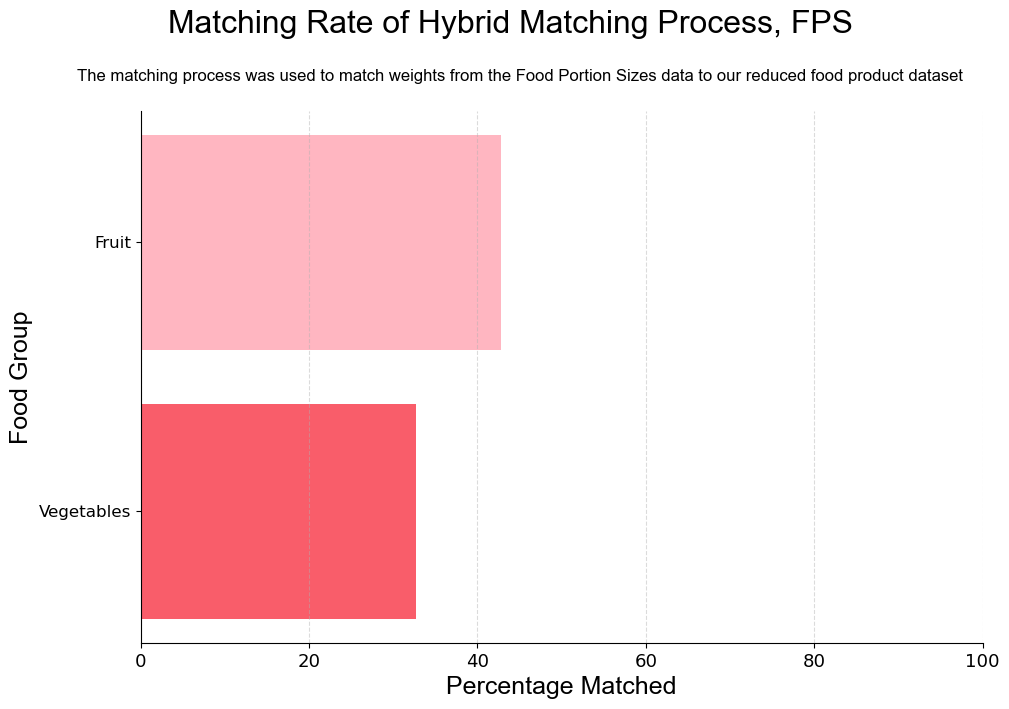

In [26]:
import matplotlib.font_manager as fm

# Find the minimum count in the ax4_counts DataFrame.
min_count4 = ax4_counts['%Matched'].min()

# Create a custom color palette.
bar_colors4 = ['lightpink' if count != min_count4 else '#f95d6a' for count in ax4_counts['%Matched']]

# Set the font family and size for the title.
title_font = fm.FontProperties(family='Arial', size=23)
subtitle_font = fm.FontProperties(family='Arial', size=12)

# Set the font family and size for the axes labels.
axis_font = fm.FontProperties(family='Arial', size=18)

# Create the figure and axes objects.
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the horizontal bar chart.
bars = ax.barh(ax4_counts['Food Group'], ax4_counts['%Matched'], color=bar_colors4)

# Add gridlines to the plot.
ax.grid(axis='x', linestyle='--', alpha=0.45)

# Customize the title, x-axis, and y-axis labels.
plt.suptitle('Matching Rate of Hybrid Matching Process, FPS',ha='center', fontproperties=title_font, y=1)  # Add y parameter
ax.set_title('The matching process was used to match weights from the Food Portion Sizes data to our reduced food product dataset', ha='center', fontproperties=subtitle_font, y=1.04, x=0.45)  # Add y parameter for subtitle
ax.set_xlabel('Percentage Matched', fontproperties=axis_font)
ax.set_ylabel('Food Group', fontproperties=axis_font)

# Set the maximum value of the x-axis to 100.
ax.set_xlim(0, 100)

# Adjust the spacing around the plot.
plt.tight_layout(pad=1.07)

# Remove the top and right spines from the plot.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase the tick label font size.
ax.tick_params(axis='x', which='major', labelsize=13)

# Adjust y-axis tick label alignment and font size.
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)

# Invert the y-axis to display the lowest match on top.
ax.invert_yaxis()

    # Show the plot.
plt.show()


                                                       Next Notebook